In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import torch
from torch.nn import *

import torchvision
from torchvision.transforms import *

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from maintrainer.loss import YoloLoss
from model import YOLOv1
from maintrainer.dataset import VOCYOLOAnnotator, VOCYolo

In [2]:
annotator = VOCYOLOAnnotator(
#     annotation_root=r'C:\Dataset\VOCdevkit\VOC2008\Annotations',
#     image_root=r'C:\Dataset\VOCdevkit\VOC2008\JPEGImages'
    annotation_root='/media/jungin500/windows-10/Dataset/VOCdevkit/VOC2008/Annotations',
    image_root='/media/jungin500/windows-10/Dataset/VOCdevkit/VOC2008/JPEGImages'
)

annotations = annotator.parse_annotation()
print("Annotation[0]:", annotations[0][0])
print("Annotation[1]:", annotations[0][1])

Annotation 내 Object Names 검색:   0%|          | 0/5096 [00:00<?, ?it/s]

Annotation 검색:   0%|          | 0/5096 [00:00<?, ?it/s]

Annotation[0]: /media/jungin500/windows-10/Dataset/VOCdevkit/VOC2008/JPEGImages/2007_000256.jpg
Annotation[1]: [[0, 3, 3, 0.4929999999999999, 0.34693877551020424, 0.966, 0.3965014577259475]]


In [3]:
%matplotlib inline
from helper.drawer import *

In [4]:
model = YOLOv1().float().cuda()

criterion = YoloLoss(lambda_coord=5, lambda_noobj=0.5)
scaler = torch.cuda.amp.GradScaler()
optimizer = torch.optim.Adam(model.parameters())

NewYoloLossV9 (CUDA not supported for now)


In [5]:
# import torchvision.transforms
# from torchvision.transforms import *
# import albumentations as A

# train_dataset = VOCYolo(
#     annotator.labels,
#     annotations,
#     transform=transforms.Compose([
# #         transforms.Resize((448, 448)),
#         transforms.ToTensor(),
# #         transforms.Normalize(
# #             mean=[0.4547857, 0.4349471, 0.40525291],
# #             std=[0.12003352, 0.12323549, 0.1392444]
# #         )
#     ]),
#     augmentations=[
#         A.PadIfNeeded(min_height=448, min_width=448),
#         A.RandomCrop(width=448, height=448),
#         A.HorizontalFlip(p=0.5),
#         A.RandomBrightnessContrast(p=0.2)
#     ]
# )

# train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=1, num_workers=0, pin_memory=True)

## Only shows first entry label as it's WRONG!

# bunch_of_batch = []
# for i, item in enumerate(train_dataloader):
#     if i >= 4:
#         break
#     bunch_of_batch.append(item)

# fig = plt.figure(figsize=(16, 16))
# fig.suptitle("GT Annotation based visualization", fontsize=24)
# for i, (image, label) in enumerate(bunch_of_batch):
#     ax = fig.add_subplot(2, 2, i + 1)
#     image = torch.squeeze(image)
#     label = torch.squeeze(label)
    
#     image = (image.numpy().transpose((1, 2, 0)) * 255).astype(np.uint8)
#     label = label.numpy()
    
#     image = Image.fromarray(image)
#     image = draw_cell_boundaries(image)
#     image = draw_center_cell_object(image, annotator, annotations[i][1])
#     ax.imshow(np.array(image))

In [6]:
import torchvision.transforms
from torchvision.transforms import *
import albumentations as A

train_dataset = VOCYolo(
    annotator.labels,
    annotations,
    transform=transforms.Compose([
#         transforms.Resize((448, 448)),
        transforms.ToTensor(),
#         transforms.Normalize(
#             mean=[0.4547857, 0.4349471, 0.40525291],
#             std=[0.12003352, 0.12323549, 0.1392444]
#         )
    ]),
    augmentations=[
        A.PadIfNeeded(min_width=448, min_height=448),
        A.RandomCrop(width=448, height=448),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2)
    ]
)

train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=1, num_workers=0, pin_memory=True)

bunch_of_batch = []
for i, item in enumerate(train_dataloader):
    if i >= 4:
        break
    bunch_of_batch.append(item)

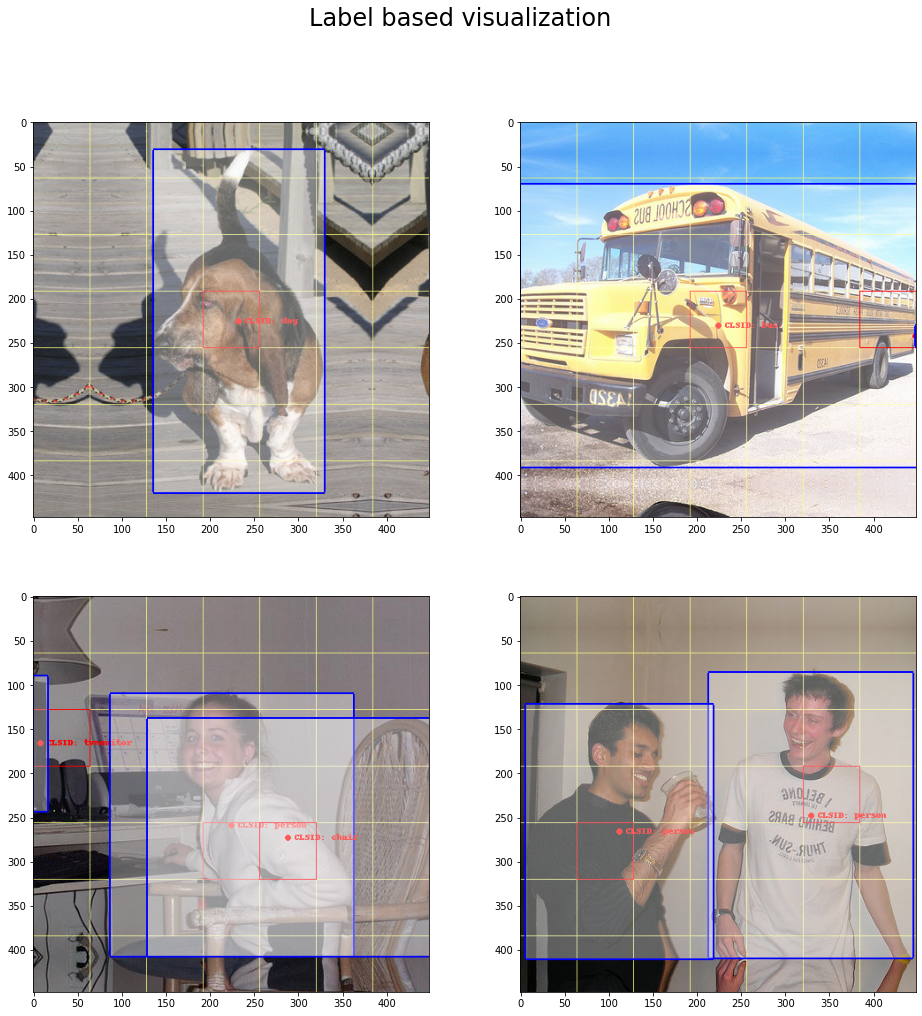

In [7]:
fig = plt.figure(figsize=(16, 16))
fig.suptitle("Label based visualization", fontsize=24)
for i, (image, label) in enumerate(bunch_of_batch):
    ax = fig.add_subplot(2, 2, i + 1)
    image = torch.squeeze(image)
    label = torch.squeeze(label)
    
    image = (image.numpy().transpose((1, 2, 0)) * 255).astype(np.uint8)
    label = label.numpy()
    
    image = Image.fromarray(image)
    image = draw_cell_boundaries(image)
    image = draw_center_cell_object_label(image, annotator, label)
    ax.imshow(np.array(image))
    
plt.show()

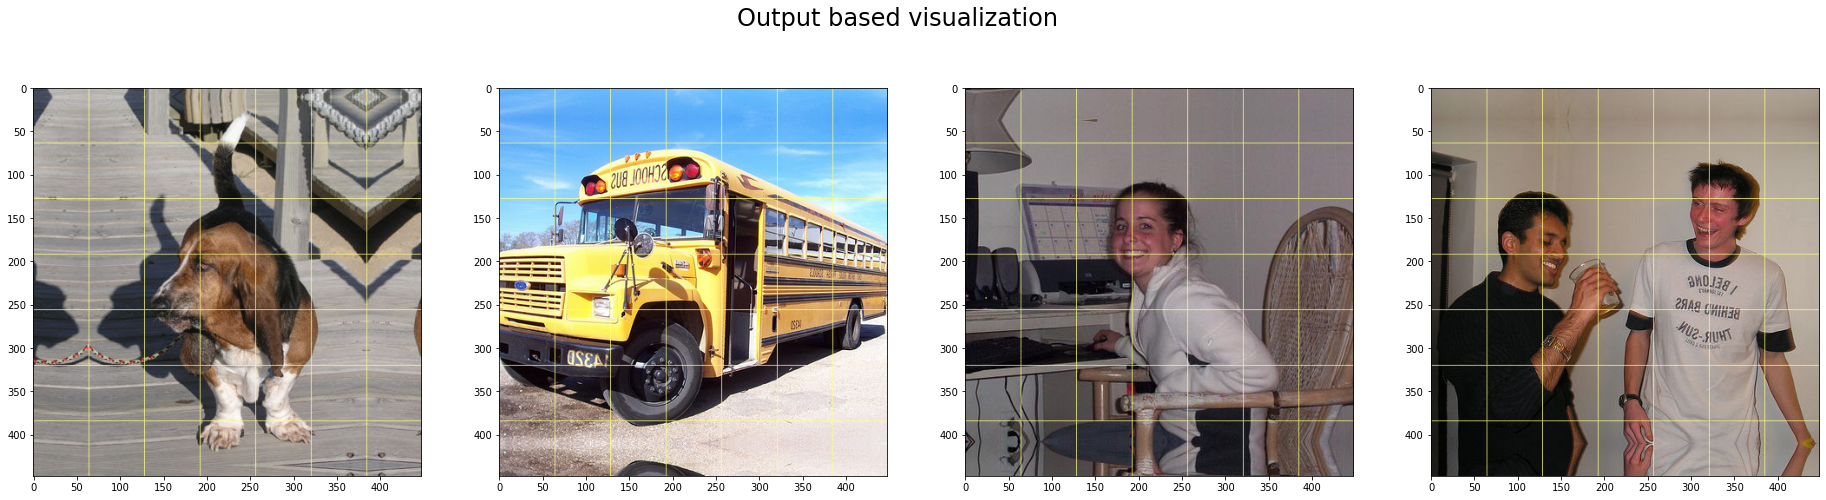

In [8]:
def do_visualization(title = None):
    fig = plt.figure(figsize=(32, 8))
    fig.suptitle("Output based visualization" if title is None else title, fontsize=24)
    
    model.eval()
    for i, (image, label) in enumerate(bunch_of_batch):
        ax = fig.add_subplot(1, 4, i + 1)

        output = model(image.cuda()).detach().cpu()

        image = torch.squeeze(image.cpu())
        output = torch.squeeze(output)

        image = (image.numpy().transpose((1, 2, 0)) * 255).astype(np.uint8)
        output = output.numpy()

        image = Image.fromarray(image)
        image = draw_cell_boundaries(image)
        image = draw_center_cell_object_output(image, annotator, output, confidence_threshold=0.51)
        ax.imshow(np.array(image))
    model.train()

    plt.show()
    
do_visualization()

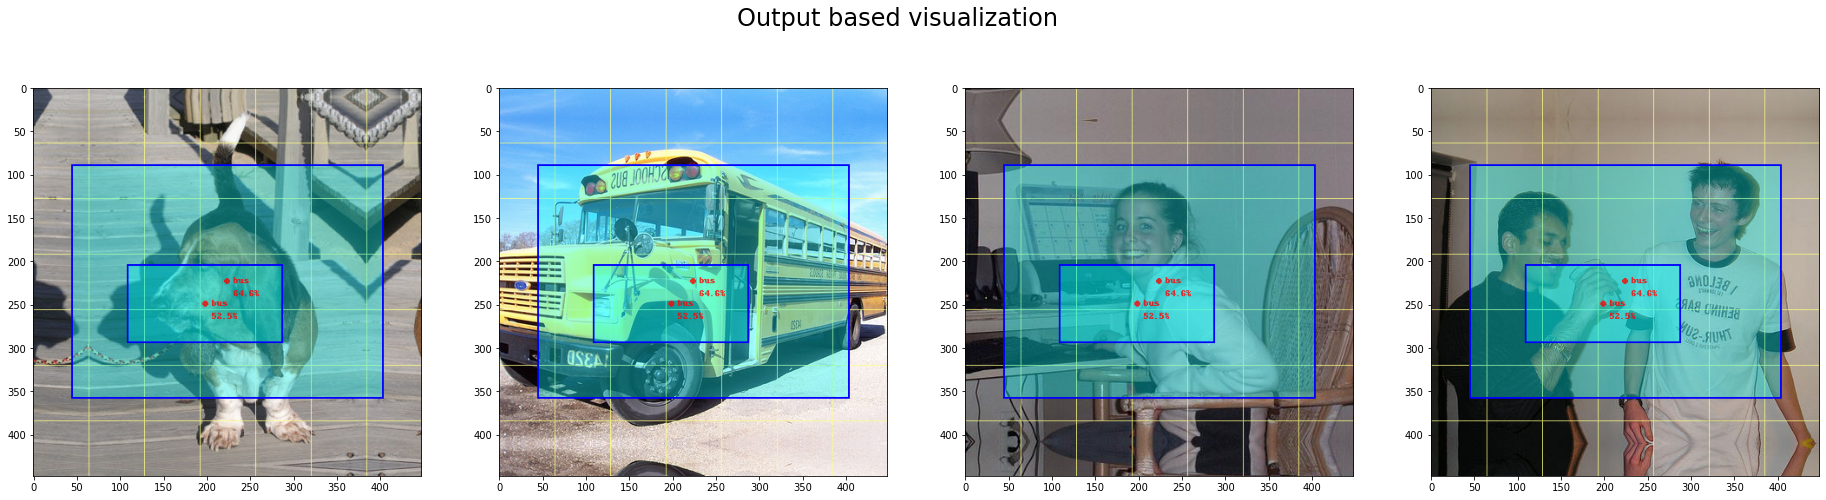

In [9]:
# Testing over pseudo-output

def do_visualization_pseudo(title = None):
    fig = plt.figure(figsize=(32, 8))
    fig.suptitle("Output based visualization" if title is None else title, fontsize=24)
    
    model.eval()
    for i, (image, label) in enumerate(bunch_of_batch):
        ax = fig.add_subplot(1, 4, i + 1)
        output = torch.zeros((1, 30, 7, 7))
        # Adds object inside center point (3, 3)
        output[0, :, 3, 3] = torch.from_numpy(np.array([
            #x, y, w, h, c, classes
            0.0, 0.0, 1.38629, 0.40547, 0.6, # 0.5, 0.5, 0.8, 0.6, 0.6,
            -2.197224, 2.197225, -0.405465, -1.3862894, 0.1, # 0.1, 0.9, 0.4, 0.2, 0.1,
            0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
        ]))

        image = torch.squeeze(image.cpu())
        output = torch.squeeze(output)

        image = (image.numpy().transpose((1, 2, 0)) * 255).astype(np.uint8)
        output = output.numpy()

        image = Image.fromarray(image)
        image = draw_cell_boundaries(image)
        image = draw_center_cell_object_output(image, annotator, output, confidence_threshold=0.51)
        ax.imshow(np.array(image))
    model.train()

    plt.show()

do_visualization_pseudo()